# Set up

In [35]:
# --- Setup / Imports ---
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

# Display settings for pandas
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 100)

# Plot settings
plt.style.use("seaborn-v0_8")
sns.set_theme()

print("Setup complete. Ready to analyze data.")




Setup complete. Ready to analyze data.


# Basic data exploration

In [36]:
# Check the DataFrame dimensions(rows and columns)

df = pd.read_csv("metadata_small.csv.gz")

print("\nDataset info:")
df.info()

# Identify data types of each column
print("\nData types:")
print(df.dtypes)

#Check for missing values

print("\nMissing Values:")
print(df.isnull().sum())

#Generate basic statistics for numerical columns

print("\nSummary Statistics:")
display(df.describe())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cord_uid          10000 non-null  object 
 1   sha               9010 non-null   object 
 2   source_x          10000 non-null  object 
 3   title             10000 non-null  object 
 4   doi               10000 non-null  object 
 5   pmcid             10000 non-null  object 
 6   pubmed_id         10000 non-null  int64  
 7   license           10000 non-null  object 
 8   abstract          7855 non-null   object 
 9   publish_time      10000 non-null  object 
 10  authors           9406 non-null   object 
 11  journal           9953 non-null   object 
 12  mag_id            0 non-null      float64
 13  who_covidence_id  0 non-null      float64
 14  arxiv_id          0 non-null      float64
 15  pdf_json_files    9010 non-null   object 
 16  pmc_json_files    6782 non

,pubmed_id,mag_id,who_covidence_id,arxiv_id,s2_id
count,1.000000e+04,0.0,0.0,0.0,0.0
mean,2.246508e+07,NaN,NaN,NaN,NaN
std,9.059700e+06,NaN,NaN,NaN,NaN
min,2.142000e+03,NaN,NaN,NaN,NaN
25%,1.717034e+07,NaN,NaN,NaN,NaN
50%,2.493047e+07,NaN,NaN,NaN,NaN
75%,3.011512e+07,NaN,NaN,NaN,NaN
max,3.238719e+07,NaN,NaN,NaN,NaN


# Data cleaning and preparation

In [37]:
# Clean data if there are missing values

df = df.dropna()
df = df.fillna(df.mean(numeric_only=True))

# Prepare data for analysis

In [38]:
# convert publish_time to datetime (invalid formats become NaT)
df = pd.read_csv("metadata_small.csv.gz")

df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
print("Total rows:", len(df))
print("Valid dates:", df['publish_time'].notna().sum())

# Drop missing dates
df = df.dropna(subset=['publish_time'])

# how many failed to parse
print("NaT count:", df['publish_time'].isna().sum())

# extract year for time-based analysis
df['year'] = df['publish_time'].dt.year

# sample
df[['publish_time','year']].head()






Total rows: 10000
Valid dates: 9078
NaT count: 0


,publish_time,year
0,2001-07-04,2001
1,2000-08-15,2000
2,2000-08-25,2000
3,2001-02-22,2001
4,2001-05-11,2001


# Data analysis and visualization

C:\Users\User\AppData\Local\Temp\ipykernel_16532\4040663645.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  papers_by_date = df.groupby(pd.Grouper(key='publish_time', freq='M')).size()


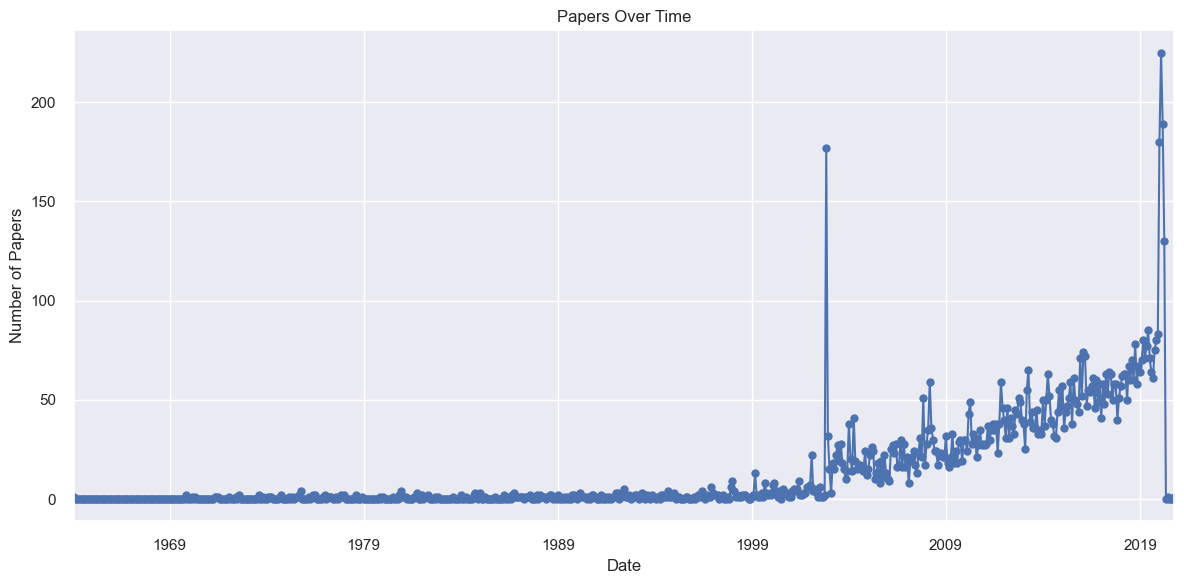

In [39]:
# Count papers per month (resample for smoother trends)
df = pd.read_csv("metadata_small.csv.gz")

df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')

papers_by_date = df.groupby(pd.Grouper(key='publish_time', freq='M')).size()

# Plot
papers_by_date.plot(kind='line', figsize=(12,6), marker='o', title="Papers Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Papers")
plt.grid(True)
plt.tight_layout()
plt.show()


# Identify top journals publishing COVID-19 research

Top Journals:
 journal
PLoS One              697
Sci Rep               335
Lancet                251
Intensive Care Med    181
Arch Virol            163
Viruses               140
PLoS Pathog           132
BMC Infect Dis        128
Crit Care             128
J Infect Dis          107
Name: count, dtype: int64


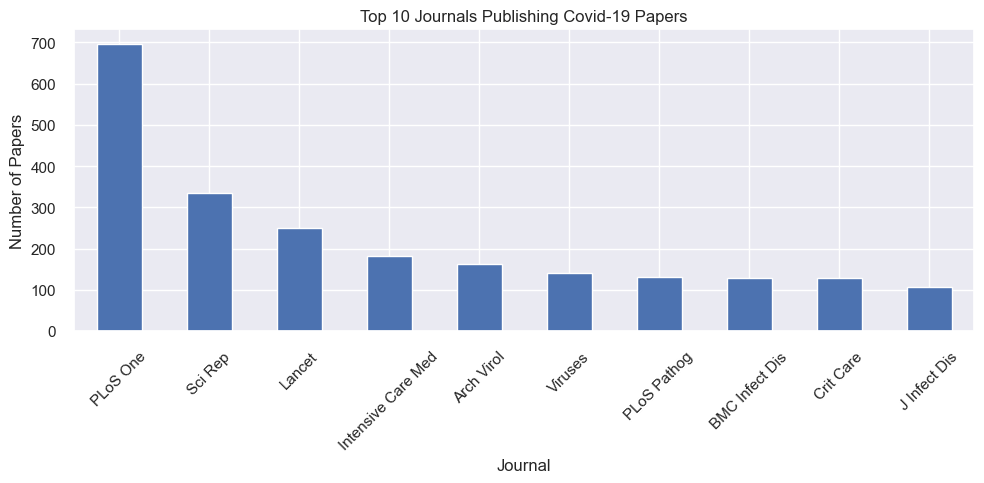

In [40]:
# Load data

df = pd.read_csv("metadata_small.csv.gz")

df['journal'] = df['journal'].replace(r'^\s*$', pd.NA, regex=True)

# Count
top_journals = df['journal'].value_counts().head(10)
print("Top Journals:\n", top_journals)

# Plot top 20 journals
if not top_journals.empty:
    top_journals.plot(kind='bar', figsize=(10, 5), title="Top 10 Journals Publishing Covid-19 Papers")
    plt.xlabel("Journal")
    plt.ylabel("Number of Papers")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No journal data available to plot.")


# Find the most frequent words in title (using simple word frequency)

Most Frequent Words in Titles:
 [('virus', 1495), ('influenza', 860), ('infection', 721), ('respiratory', 583), ('human', 558), ('disease', 478), ('patients', 460), ('cell', 453), ('viral', 436), ('cells', 405), ('acute', 398), ('protein', 394), ('analysis', 372), ('health', 366), ('study', 353), ('infections', 313), ('syndrome', 286), ('against', 274), ('clinical', 272), ('associated', 270)]


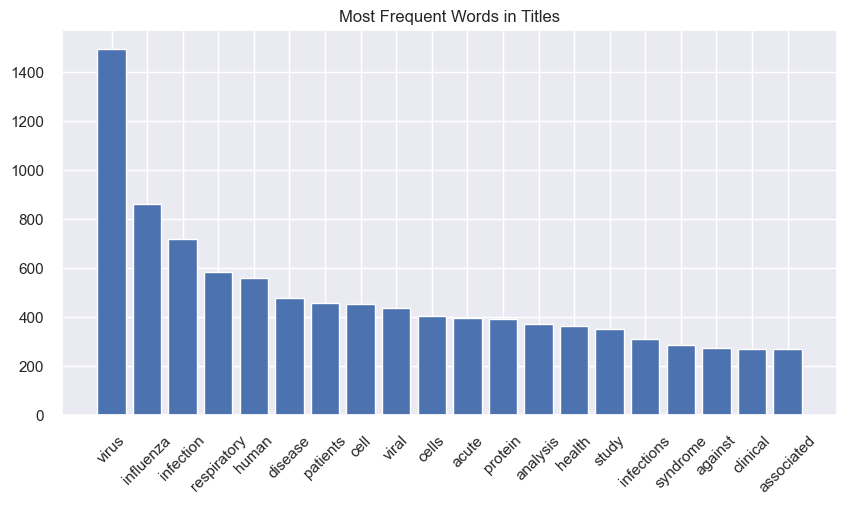

In [41]:


# Most frequent words in title

# Define a basic stopword list
stopwords = {
    "of","in","and","the","for","with","to","on","by","from","an","a","at",
    "is","are","be","as","that","this","it","its","into","was","were","or"
}

# Combine all titles into one sting
all_text = " ".join(df['title'].dropna().astype(str).tolist()).lower()

# Extract words (at least 2 letters)
words = re.findall(r'\b[a-z]{2,}\b', all_text)

# Remove stopwords
filtered_words = [w for w in words if w not in stopwords]

# Count frequencies
word_freq = Counter(filtered_words).most_common(20)

print("Most Frequent Words in Titles:\n", word_freq)

# --- Plot ---
if word_freq:
    words, counts = zip(*word_freq)
    plt.figure(figsize=(10,5))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title("Most Frequent Words in Titles")
    plt.show()
else:
    print("No words extracted. Check if 'title' column has values.")

# Wordcloud of paper titles

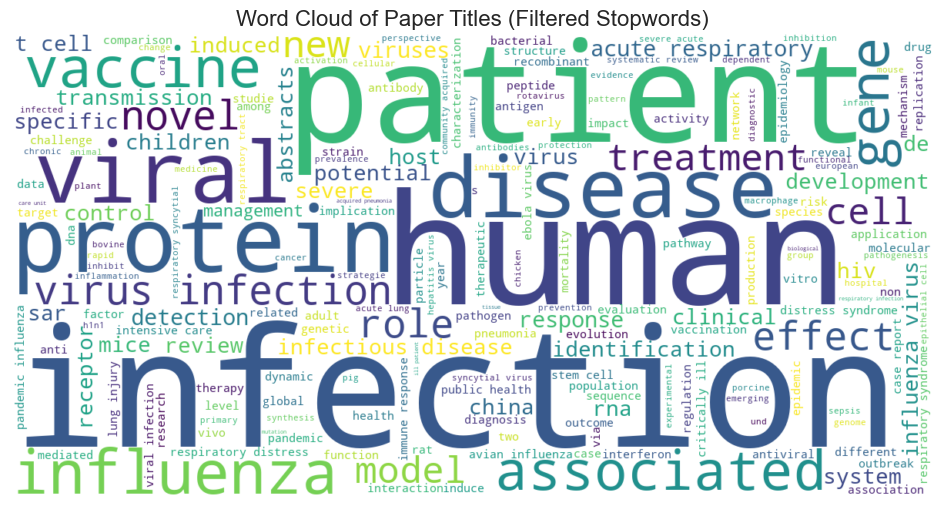

In [42]:
# Combine all paper titles into one string
all_titles = " ".join(df['title'].dropna().astype(str).tolist()).lower()

# Define stopwords
stopwords = set(STOPWORDS)
stopwords.update(["using", "based", "study", "analysis", "of","in","and","the","for","with","to","on","by","from","an","a","at",
    "is","are","be","as","that","this","it","its","into","was","were","or", "abstract", "expression","following", "high","type","approach","use","method" ])

# Generate word cloud
wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    colormap="viridis",
    stopwords=stopwords
).generate(all_titles)

# Display
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Paper Titles (Filtered Stopwords)", fontsize=16)
plt.show()

# Distribution of paper counts by source

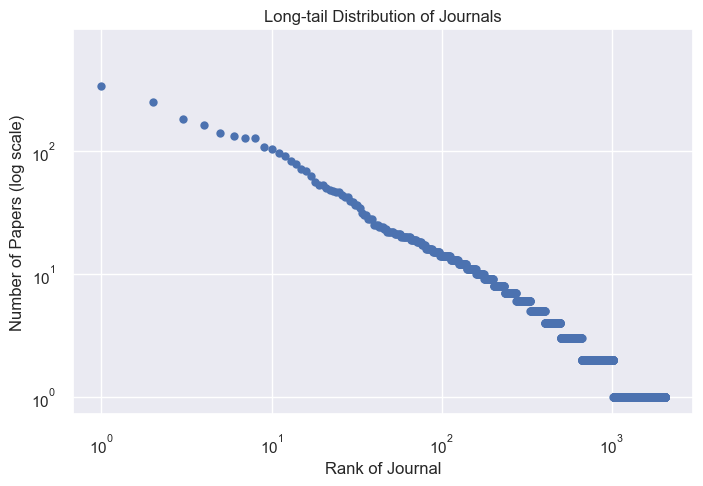

In [43]:

# Count papers per journal
journal_counts = df['journal'].value_counts()

# Long-tail distribution (log-log plot)
plt.figure(figsize=(8,5))
journal_counts.reset_index(drop=True).plot(logy=True, logx=True, marker='o', linestyle='none')
plt.title("Long-tail Distribution of Journals")
plt.xlabel("Rank of Journal")
plt.ylabel("Number of Papers (log scale)")
plt.show()

